# CP Factorization

## Initialization of libraries and Dataset

In [1]:
%matplotlib inline
import os
import sys
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from datetime import datetime, date
from sklearn.metrics import precision_recall_curve, average_precision_score

from sktensor import dtensor, cp_als
from numpy import linalg as LA

matplotlib.style.use('ggplot')

In [4]:
# Downloading and preprocessing the dataset
# The variable "tab" has integers datetime
execfile('Library/Initialization_rado_week.py')
tab.head()

82927 mails exchanged between 167 employees from 0.0 to 38.0
9.68904495239


,sender,receiver,datetime,week
0,1,2,733774,0
1,1,3,733774,0
2,1,4,733774,0
3,1,5,733774,0
4,1,6,733774,0


In [5]:
T.shape

(167, 167, 39)

## Tensor Factorization

### Dataset Temporal Split
We use (sender,receiver)_t matrix for t between t_0 and t_1. This temporal window shifts as t_0 incresases.  
t_0 is s.t. t_0+t_1 <= T.shape[2] = 39  
  
Since we would like to move this window around 3 weeks, we choose t_0 <= 2 and a constant window size of length 9-7=2

In [7]:
t_0 = 0
t_1 = t_0 + 20

if t_1 <= T.shape[2]:
    T_train = T[:, :, t_0:t_1]
    T_test = T[:, :, t_1:]
    print('Initial time: t_0 = %d [%d]\nFinal time:   t_1 = %d [%d]') %(t_0,k_list[t_0],
                                                                                  t_1,
                                                                                  k_list[t_1])
else:
    print('t_0=%d is superior to the maximal value 21!') %(t_0)

Initial time: t_0 = 0 [0]
Final time:   t_1 = 20 [20]


In [8]:
#Proportion of non-zero entries of the tensor
mail_rate = np.count_nonzero(T) / float(T.shape[0] * T.shape[1] * T.shape[2])

In [9]:
mail_rate

0.03138540974246808

### CanDecom/ParaFac (CP) Decomposition

In [10]:
# Defining a function for the outer product of several vectors
def Outer(vecs):
    # vecs can be either a list of vectors (n vectors of dimensions (**,1)) or an array of dimensions (**, n)
    vec_list = []
    if isinstance(vecs, list):
        vec_list = vecs
    elif isinstance(vecs, np.ndarray):
        vec_list = [vecs[:, j] for j in range(vecs.shape[1])]        

    res = reduce(np.multiply, np.ix_(*vec_list))
    return res

In [9]:
K = 20 # rank parameter of the CP
%time P, fit, itr, exectimes = cp_als(T_train, K, init='random')
A, B, C = P.U

CPU times: user 28.7 s, sys: 10.6 s, total: 39.3 s
Wall time: 35.3 s


In [9]:
# Two equivalent ways of computing the approximation of T_train

T_approx1 = P.totensor()
T_approx2 = sum(map(lambda x: P.lmbda[x]*Outer([A[:, x],
                                                B[:, x],
                                                C[:, x]]), range(K)))

np.allclose(T_approx1, T_approx2)

True

In [10]:
del T_approx1, T_approx2

### CP Scoring

In [11]:
# Collapsed Unweighted Tensor [P04]
tau = 60
gamma = sum(C[-tau:, :], 0)  # The temporal coefficient

S = sum(map(lambda x: gamma[x]*P.lmbda[x]*Outer([A[:, x],
                                                 B[:, x]]), range(K)))
print('Predicting time: %s \nTraining window: %d to %d \nTau_Window: %d dates from %d to %d' %(k_list[t_1],
                                                                                               k_list[t_0],
                                                                                               k_list[t_1-1],
                                                                                               tau,
                                                                                               k_list[t_1-tau],
                                                                                               k_list[t_1-1]))

Predicting time: 734031 
Training window: 733782 to 734030 
Tau_Window: 60 dates from 733960 to 734030


In [11]:
#Converting S into S_pred, a binary matrix
#thres = 1  # If the score above thres, we predict an email

#S_pred = (1*(S >= thres))
S_test = (1*np.array(T_test[:, :, 0] >= 1))

## Scoring Analysis

### Maximal prediction

In [10]:
# Which pair of (sender, receiver) has a maximal score? 
i_ind, j_ind = np.unravel_index(S.argmax(), S.shape)
i, j = i_list[i_ind], j_list[j_ind]
print('Predicted Score for sender %d to receiver %d for time %d: %d mails'%(i,
                                                                            j,
                                                                            k_list[t_1],
                                                                            round(S[i_ind, j_ind])))

Predicted Score for sender 13 to receiver 14 for time 734031: 21 mails


In [11]:
X_max = X.ix[(X.sender == i)&(X.receiver == j)&(X.datetime <= k_list[t_1])]

nb_train = len(X_max.ix[X.datetime < k_list[t_1]])
nb_train_tau = len(X_max.ix[(X.datetime < k_list[t_1])&(X.datetime >= k_list[t_1-tau])])
nb_test = len(X_max.ix[X.datetime == k_list[t_1]])

print('%d mails sent during the trainset with %d during the tau-selected window. \n%d mails actually sent at time %d' \
      %(nb_train,
        nb_train_tau,
        nb_test,
        k_list[t_1]))

1346 mails sent during the trainset with 97 during the tau-selected window. 
21 mails actually sent at time 734031


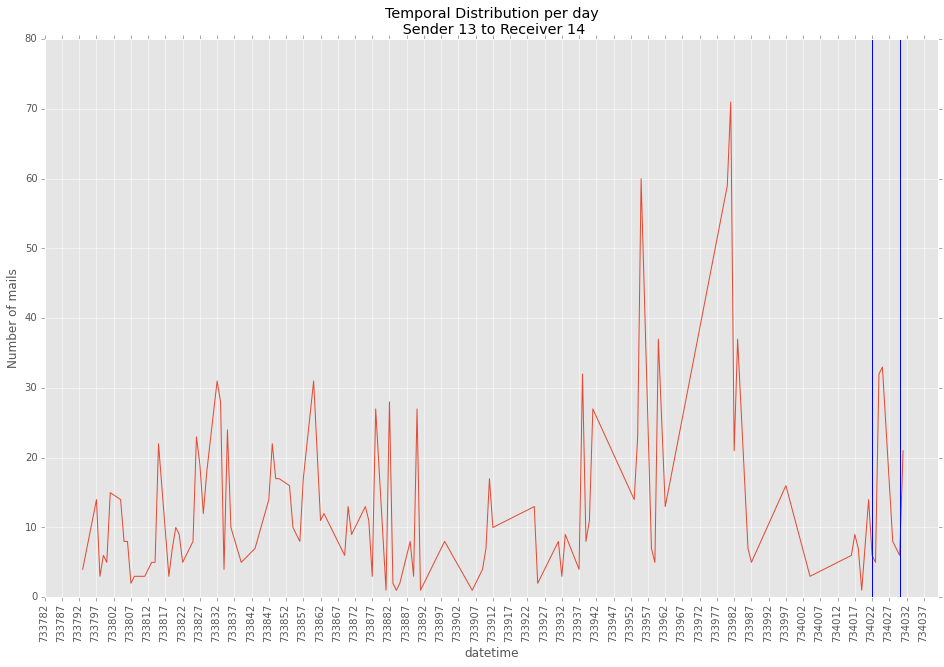

In [12]:
X_max_count = X_max.datetime.groupby(X_max.datetime).count()

plt.figure(figsize=(16, 10))
plt.title('Temporal Distribution per day \n Sender %d to Receiver %d ' %(i, j))
plt.ylabel('Number of mails')
plt.xlabel('datetime')
plt.xlim([k_list[t_0], k_list[t_1]+10])
plt.grid('on')
plt.plot(X_max_count.index, X_max_count)
plt.xticks(np.arange(k_list[t_0], k_list[t_1]+10, 5), rotation=90)
plt.ticklabel_format(useOffset=False)

plt.axvline(k_list[t_1-tau])
plt.axvline(k_list[t_1-1])

### Factorization Analysis

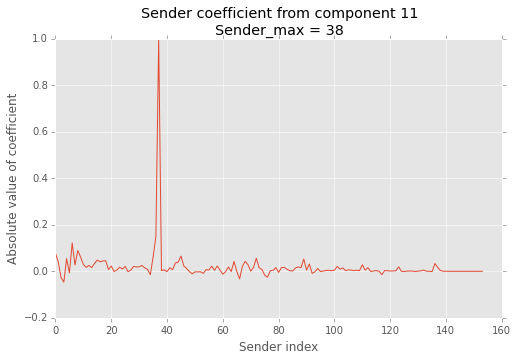

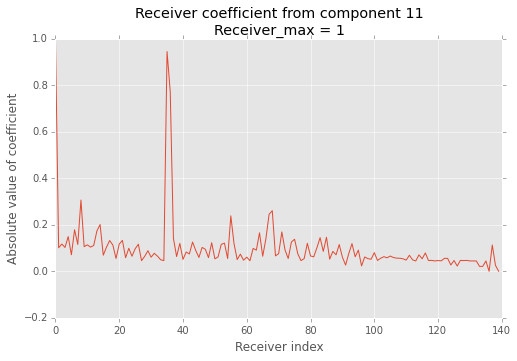

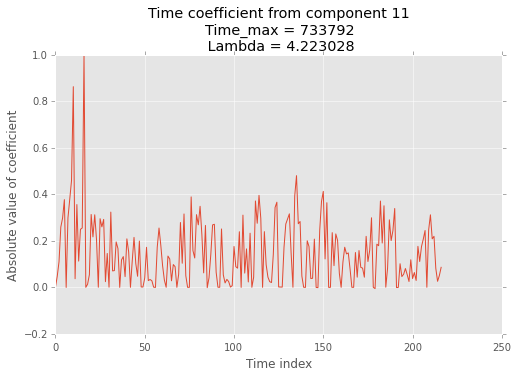

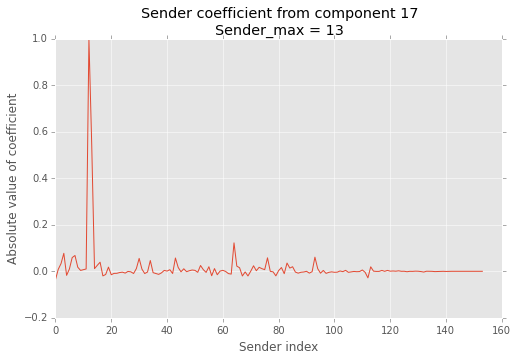

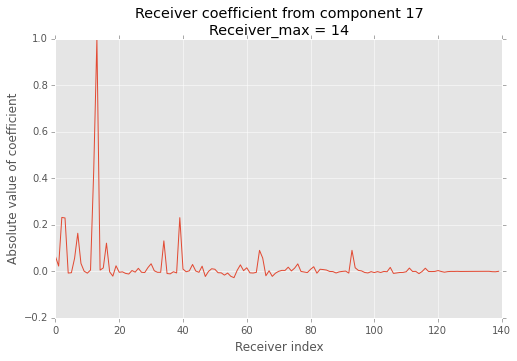

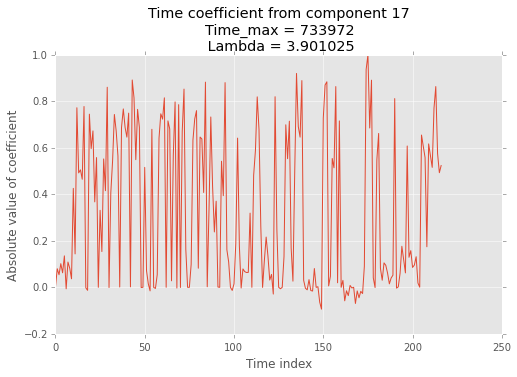

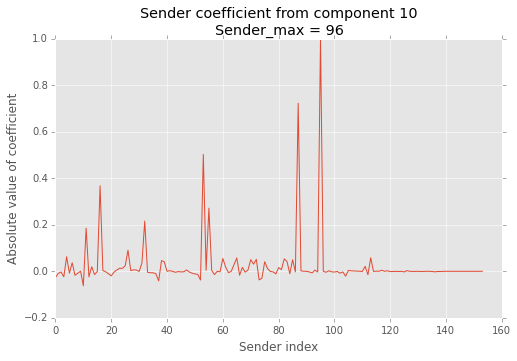

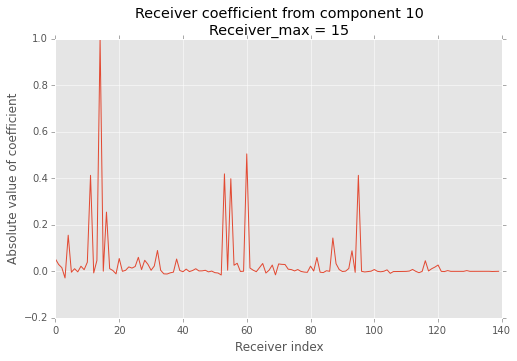

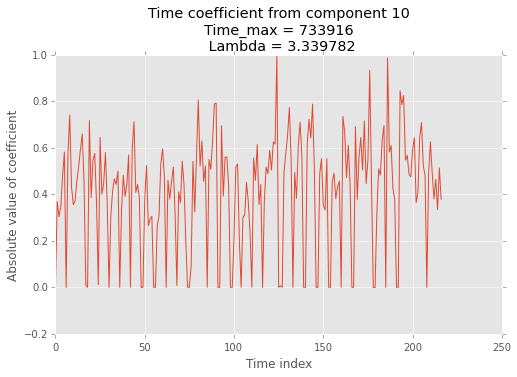

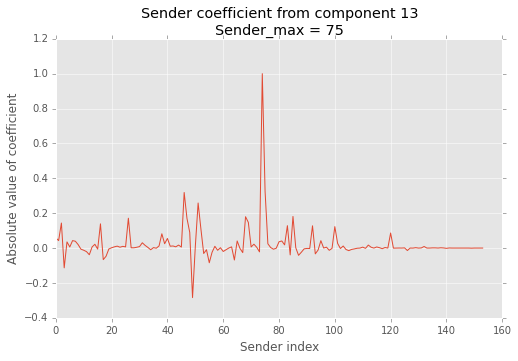

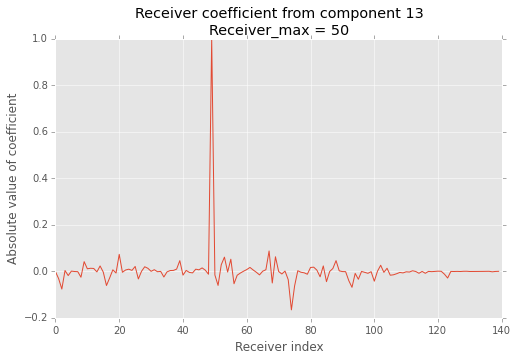

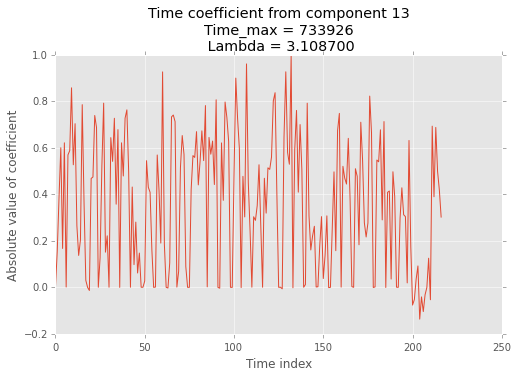

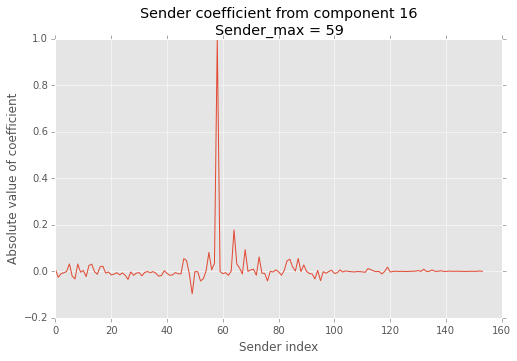

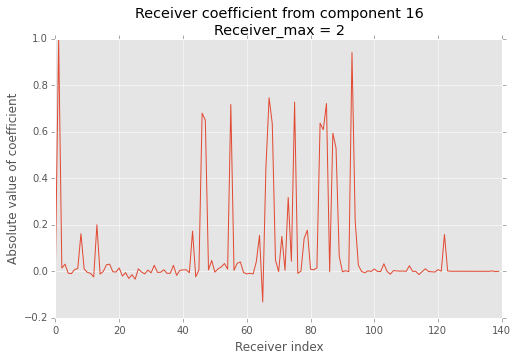

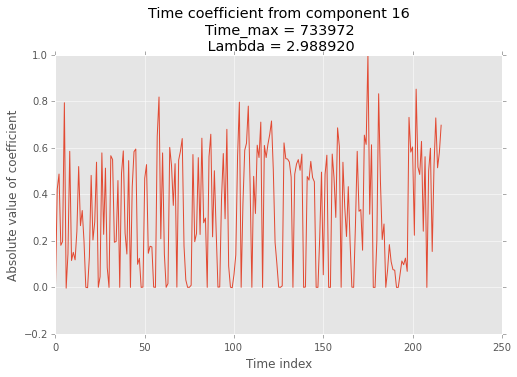

In [13]:
for k in (-P.lmbda).argsort()[:5]:
    i_ind = abs(A[:, k]).argmax()
    i_max = i_list[i_ind]

    j_ind = abs(B[:, k]).argmax()
    j_max = j_list[j_ind]

    k_ind = abs(C[:, k]).argmax()
    k_max = k_list[k_ind]

    plt.figure(figsize=(8, 5))
    plt.title('Sender coefficient from component %d \nSender_max = %d' %((k+1), i_max))
    plt.ylabel('Absolute value of coefficient')
    plt.xlabel('Sender index')
    plt.plot(A[:, k])

    plt.figure(figsize=(8, 5))
    plt.title('Receiver coefficient from component %d \nReceiver_max = %d' %((k+1), j_max))
    plt.ylabel('Absolute value of coefficient')
    plt.xlabel('Receiver index')
    plt.plot(B[:, k])

    plt.figure(figsize=(8, 5))
    plt.title('Time coefficient from component %d \nTime_max = %d \n Lambda = %f' %((k+1), k_max, P.lmbda[k]))
    plt.ylabel('Absolute value of coefficient')
    plt.xlabel('Time index')
    plt.plot(C[:, k])

### Precision-Recall for several values of K
Collapsed Unweighted Tensor

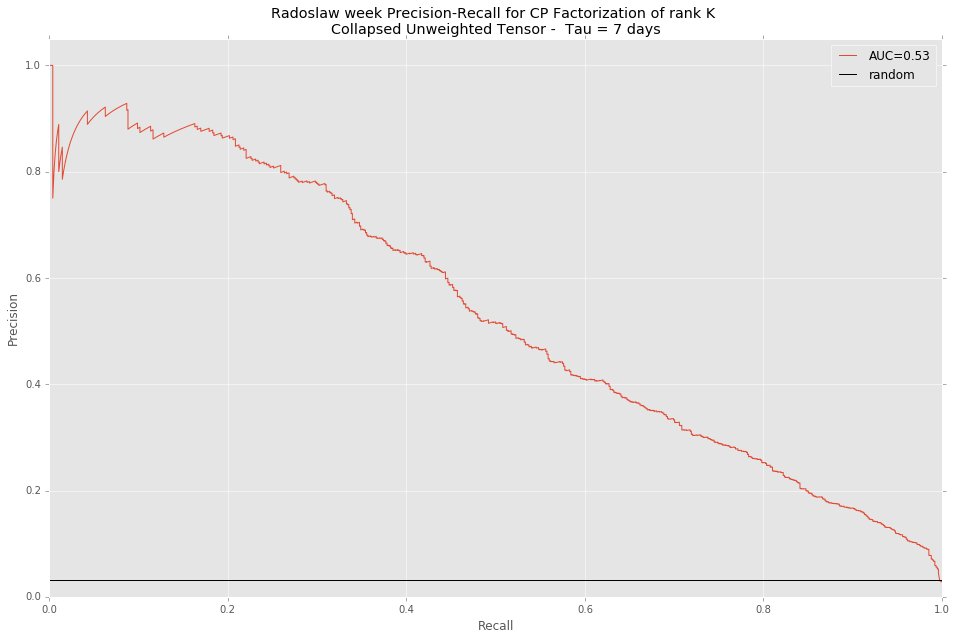

In [14]:
K_list = [1, 5, 10, 30, 50]
#tau_list = [1, 7, 30]
S = np.zeros((T_train.shape[0], T_train.shape[1]))
tau_list= [7]

for tau_ind in range(len(tau_list)):
    # Choice of tau
    tau = tau_list[tau_ind]
    # Initialization
    precision = dict()
    recall = dict()
    average_precision = dict()
    for K_ind in range(len(K_list)):
        # Choice of K
        K = K_list[K_ind]
        # CP Decomposition
        P, fit, itr, exectimes = cp_als(T_train, K, init='random')
        A, B, C = P.U
        # CP Scoring
        gamma = sum(C[-tau:, :], 0)  # The temporal coefficient
        Sk = sum(map(lambda x: gamma[x]*P.lmbda[x]*Outer([A[:, x], B[:, x]]), range(K)))
        for i in range(Sk.shape[0]) :
            for j in range(Sk.shape[1]) :
                Sk[i,j] = float(Sk[i,j])
        S += Sk/LA.norm(Sk, 'fro')

y_score = S.flatten()
y_test = (1*np.array(T_test[:, :, 0] >= 1)).flatten()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)    

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

plt.plot(recall, precision, label='AUC={0:0.2f}' .format(average_precision))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw week Precision-Recall for CP Factorization of rank K \nCollapsed Unweighted Tensor -  Tau = %d days' %(tau))
plt.savefig('Radoslaw week cp_roc_cut_%d.png' %(tau))    
   

### Precision-Recall for several values of K
Exponential Smoothing

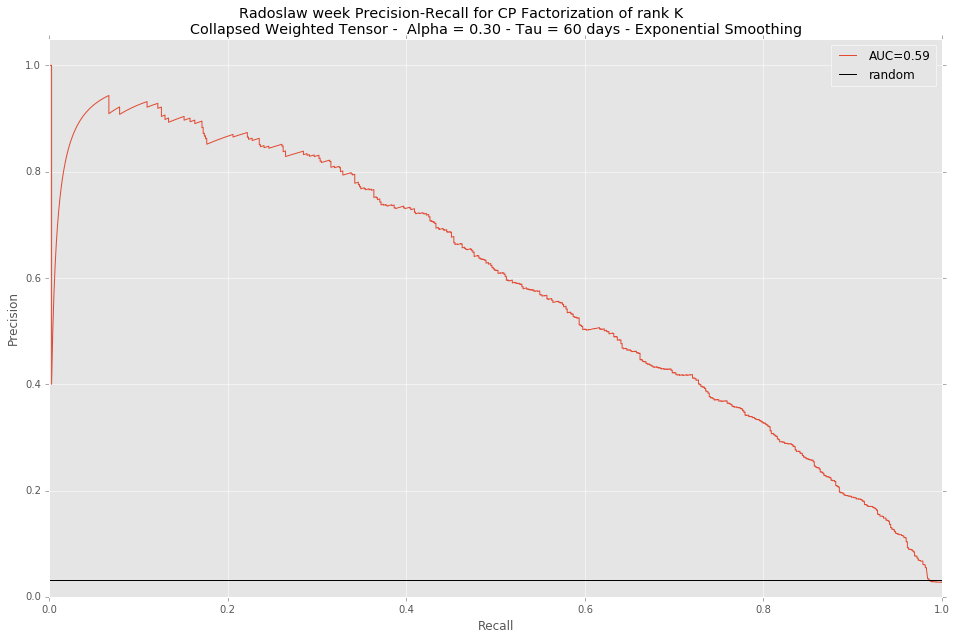

In [15]:
K_list = [1, 5, 10, 30, 50]
#tau_list = [1, 7, 20]
tau_list = [60]
#alpha_list = [0.2, 0.5, 0.8]
alpha_list = [0.3] 

for alpha_ind in range(len(alpha_list)):
    # Choice of alpha
    alpha = alpha_list[alpha_ind]
    for tau_ind in range(len(tau_list)):
        # Choice of tau
        tau = tau_list[tau_ind]

        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # CP Decomposition
            P, fit, itr, exectimes = cp_als(T_train, K, init='random')
            A, B, C = P.U
            # CP Scoring
            gamma = sum(map(lambda x: ((1 - alpha) ** x) * alpha * C[-x, :], range(t_1 - t_0 - 1)), 0) + \
                    (1 - alpha) ** (t_1 - t_0 + 1) * C[0, :]                                 # Exponential smoothing
            for i in range(Sk.shape[0]) :
                for j in range(Sk.shape[1]) :
                    Sk[i,j] = float(Sk[i,j])
            S += Sk/LA.norm(Sk, 'fro')

y_score = S.flatten()
y_test = (1*np.array(T_test[:, :, 0] >= 1)).flatten()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)    

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

plt.plot(recall, precision, label='AUC={0:0.2f}' .format(average_precision))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw week Precision-Recall for CP Factorization of rank K \
              \nCollapsed Weighted Tensor -  Alpha = %.2f - Tau = %d days - Exponential Smoothing' %(alpha, tau))
plt.savefig('Radoslaw week cp_roc_cwt_%.2f_%d Exponential Smoothing.png' %(alpha, tau))    